# Wie optimiert man Hyperparameter?

## Imports and Version Selection

In [0]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Tue Mar 31 19:25:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    30W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Proce

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

# jupyters magic command
%matplotlib inline

Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.18)


## Loading and Preprocessing

In [0]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    resized_image = resized_image / 255
    return resized_image, label

In [0]:
# download the dataset with labels and with information about the data
data, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# print the most important information
dataset_size = info.splits['train'].num_examples
print('dataset size: ', dataset_size)
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

batch_size = 32

try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
  test_data = tfds.load('tf_flowers', split="train[80%:100%]", as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess)
  test_data = test_data.map(preprocess)
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True)
  test_data = tfds.load('tf_flowers', split=test_split, as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess)
  test_data = test_data.map(preprocess)

# convert tf.dataset to numpy array
X, y, X_test, y_test = helpers.dataset_to_ndarray(train_data, test_data)

dataset size:  3670
class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
number of classes:  5


## Show sample images

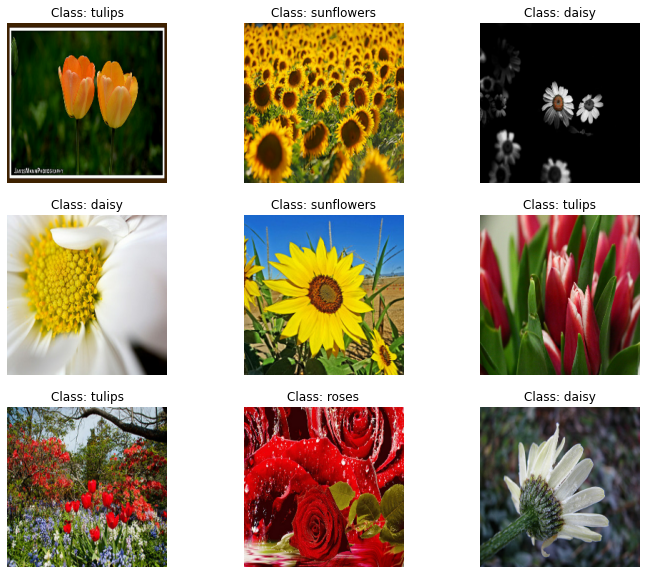

In [0]:
# show some images from the dataset
helpers.plot_images(train_data.take(9), class_names)

## Definition and Training

In [0]:
# returns a compiled keras model with the parameters given
def wrap_model(
    learning_rate=0.001, 
    momentum=0.9,
    decay=0.001, 
    dense_neurons=1000,
    n_filters=32,
    first_kernel_size=(7,7)
):

  activation='elu'

  input_layer = Input(shape=(224, 224, 3))

  model = Conv2D(
      filters=n_filters, 
      kernel_size=(7,7), 
      activation=activation
  )(input_layer)
  model = MaxPooling2D((2,2))(model)

  for i in range(2, 5):
    model = Conv2D(
        filters = i * n_filters, 
        kernel_size=(3,3), 
        activation=activation
      )(model)
    model = MaxPooling2D((2,2))(model)

  model = Conv2D(
      filters = 5 * n_filters, 
      kernel_size=(3,3), 
      activation=activation, 
      padding='same'
    )(model)
  model = MaxPooling2D((2,2))(model)

  model = Flatten()(model)
  model = Dense(dense_neurons, activation=activation)(model)
  # model = Dense(dense_neurons / 2, activation='tanh')(model)
  model = Dense(dense_neurons / 2, activation='tanh')(model)

  output = Dense(n_classes, activation="softmax")(model)

  CNN_model = Model(input_layer, output)

  optimizer = keras.optimizers.SGD(
      lr=learning_rate, 
      momentum=momentum, 
      decay=decay
  )
  CNN_model.compile(
      loss="sparse_categorical_crossentropy", 
      optimizer=optimizer,
      metrics=["accuracy"]
  )
  
  return CNN_model

In [0]:
CNN_model = wrap_model()
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 96)        0     

## Grid Search

In [0]:
keras_regressor = tf.keras.wrappers.scikit_learn.KerasRegressor(wrap_model)

In [0]:
params_grid = {
    'learning_rate':[ 0.0001, 0.001], 
    'dense_neurons':[200, 1000],
    'n_filters':[16, 32]
}

In [0]:
grid_search = GridSearchCV(keras_regressor, params_grid)
grid_search.fit(X, y, epochs=20, validation_data=(X_test,y_test))

#### Visualisation of Grid Search results

In [0]:
print("Best sklearn-Score: ", grid_search.best_score_)

In [0]:
print("Best Parameters: ", grid_search.best_params_)

In [0]:
print("All results: ", grid_search.cv_results_)

In [0]:
best_model = grid_search.best_estimator_

## Randomized Search

In [0]:
params_random = {
    'learning_rate':[0.0001, 0.001, 0.01], 
    'momentum':[0.9, 0.99, 0.999],
    'decay':[0.1, 0.01, 0.001, 0.0001], 
    'dense_neurons':[200, 500],# 1000, 2000],
    'n_filters':[16, 32, 64],
    'first_kernel_size':[(3,3), (5,5), (7,7)]
}

In [0]:
random_search = RandomizedSearchCV(keras_regressor, params_random, n_iter=20)
random_search.fit(X, y, epochs=20, validation_data=(X_test, y_test))

#### Visualization of Randomized Search Results

In [0]:
print("Best sklearn-Score: ", random_search.best_score_)

In [0]:
print("Best Parameters: ", random_search.best_params_)

In [0]:
print("All results: ", random_search.cv_results_)

In [0]:
best_model = random_search.best_estimator_